# Analysing NOAA Images obtained with Satdump

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danselem/dara_opsc/blob/main/image-analysis.ipynb)


<div style="text-align: center;">
  <img src="https://www.nesdis.noaa.gov/s3/styles/webp/s3/migrated/JPSS-1.jpg.webp?itok=KGtqS1df" width="1000"/>
</div>

In this tutorial, we will be using the NOAA data obtained on the 11th of July 2025 with Satdump.

The data comprises multiple images images including transformations performed with Satdump as well as the product parameters. This tutorial is performed with Python and is run in a Jupyter Notebook environment running in a Google Colab instance.

If you're not familiar with Python, then I recommend you check out Week 1 of this GitHub project repo: <https://github.com/Danselem/brics_astro/tree/main/Week1>.

## Installing Packages

In Python, **packages** are reusable blocks of code developed by the open-source community.  
They save time by allowing us to use tested functions and tools instead of writing everything from scratch.  
For this project, we will install a few essential packages using **Pip**, Python’s package manager.

- **`cbor2`** — Handles **CBOR (Concise Binary Object Representation)** files, a compact binary format used to store structured data such as satellite product metadata.  
- **`skyfield`** — Performs precise **astronomical and orbital calculations**, helping us determine satellite positions, trajectories, and observation times.  
- **`cartopy`** — A **mapping and geospatial visualization** library for displaying satellite footprints, coastlines, and projections on global maps.  
- **`rasterio`** — Enables reading and writing of **raster-based geospatial images**, allowing us to georeference satellite data and extract pixel information.  
- **`scikit-image`** — Provides a wide range of **image processing algorithms** for filtering, segmentation, and feature extraction such as edge or texture detection.  
- **`opencv-python`** — A powerful **computer vision** library used for image enhancement, artifact detection, and motion or object analysis.  


In [ ]:
!pip install -q cbor2 skyfield cartopy rasterio
!pip install -q scikit-image opencv-python

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import cbor2

### Downloading Data
We will be using the NOAA data obtained on the 11th of July over the area of Mauritius.

In [ ]:
!wget https://raw.githubusercontent.com/Danselem/dara_opsc/main/data/noaa_apt_137MHz.zip
!unzip noaa_apt_137MHz.zip

### Reading Satellite Product Metadata

This code snippet reads a satellite product stored in the Concise Binary Object Representation (CBOR) format. CBOR is a compact and efficient binary serialization widely used for Earth observation data. The file is opened in binary mode and parsed using `cbor2.load`, which reconstructs the original Python dictionary containing the complete product metadata.  

The decoded metadata includes imaging parameters such as image width, height, and timestamps; satellite orbital data, including the Two-Line Element (TLE) information; and projection configuration parameters, such as scan angles and acquisition times. Together, these components form the foundational dataset required for geospatial analysis.  

This metadata will be used later to compute geometric and spatial metrics such as the satellite subpoint, along-track and across-track ground coverage, pixel dimensions, total imaged area, and field of view (FoV), which are essential for accurate georeferencing and visualization of satellite imagery within a global coordinate reference system.

In [6]:
# Read CBOR file
with open("2025-07-11_05-39_noaa_apt_137MHz/product.cbor", "rb") as f:
    product = cbor2.load(f)

### Inspecting the Data

In [5]:
product.get('projection_cfg', {})

{'gcp_spacing_x': 30,
 'gcp_spacing_y': 30,
 'image_width': 909,
 'pitch_offset': 0,
 'roll_offset': -0.01,
 'scan_angle': 110.6,
 'timefilter': {'max_diff': 1.0, 'scan_time': 0.2, 'type': 'simple'},
 'timestamp_offset': 0.1,
 'type': 'noaa_apt_single_line',
 'yaw_offset': -0.6}

In [6]:
product.get('tle', {})

{'line1': '1 33591U 09005A   25191.84763408  .00000140  00000+0  98745-4 0  9994',
 'line2': '2 33591  98.9961 256.7258 0012673 275.6010  84.3716 14.13387505846262',
 'name': 'NOAA 19',
 'norad': 33591}

In [8]:
timestamps = product.get('timestamps', [])
print(len(timestamps))

860


## Computing Metrics from Product

This section computes essential geometric and temporal metrics that describe how a satellite captures an image of the Earth's surface. Using the product’s timestamps and Two-Line Element (TLE) data, the function determines the mid-acquisition time, sub-satellite points, along-track and across-track distances, pixel resolutions, total ground area, and field of view. These parameters together define the spatial coverage, scale, and imaging geometry of the satellite observation.

The calculations combine geodesy, trigonometry, and photogrammetric principles — for example, the haversine formula estimates along-track distances, while the swath width is derived from the satellite’s altitude and sensor field of view. This allows one to relate image pixels to real ground distances and interpret satellite imagery in a physically meaningful way.  

An illustration of the satellite imaging geometry, showing the along-track, across-track, swath, and field-of-view relationships, is presented in Figure 1.

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/Danselem/dara_opsc/main/satimage.png" width="450"/>
  <p><strong>Figure 1.</strong> Satellite imaging geometry showing along-track, across-track, swath, and field-of-view (FOV) relationships.</p>
</div>

<div style="text-align: center;">
  <img src="https://media.licdn.com/dms/image/v2/D4D12AQGySUBnHz1a7A/article-inline_image-shrink_1000_1488/article-inline_image-shrink_1000_1488/0/1738490850480?e=2147483647&v=beta&t=azQvfXHUxocEk_JxOkxcsR7Fb1fXxxi2CUxqYsrKZ4c" width="800"/>
  <p><strong>Figure 2.</strong> Satellite imaging geometry showing along-track, across-track, swath, and field-of-view (FOV) relationships.</p>
</div>


## Metrics Description

This section explains each metric derived from the satellite product and its scientific significance in the context of Earth observation. These metrics link satellite orbital geometry, sensor characteristics, and image representation on the ground.

**image_width_px** and **image_height_px** represent the number of pixels along the across-track (width) and along-track (height) directions of the image. The width comes from the projection configuration, while the height is inferred from the number of timestamps, each corresponding to one scan line in APT-like sensors. Together, they define the sampling grid of the sensor.

**mid_datetime** is the acquisition time at the midpoint of the image, computed as the mean of the first and last timestamp:

$$
t_\text{mid} = \frac{t_0 + t_N}{2}
$$

It serves as the temporal reference for locating the satellite and aligning the image with ground coordinates.

**mid_subpoint** is the geographic location (latitude, longitude) and altitude of the satellite at the mid-acquisition time. Using Skyfield and the satellite’s TLE, the satellite’s position is propagated to this time, and the subpoint corresponds to the location on Earth directly below the satellite. This defines the image center on the ground.

**first_subpoint** and **last_subpoint** denote the sub-satellite positions at the beginning and end of the acquisition. They determine the endpoints of the satellite’s ground track and help calculate how far the satellite moved during imaging.

**along_track_length_km** measures the ground distance between the first and last subpoints along the orbit, using the haversine formula to account for Earth’s curvature:

$$
d = 2 R \arcsin \left( \sqrt{ \sin^2 \frac{\Delta \phi}{2} + \cos \phi_1 \cos \phi_2 \sin^2 \frac{\Delta \lambda}{2} } \right)
$$

where $\Delta \phi$ and $\Delta \lambda$ are the differences in latitude and longitude (in radians), and $R$ is Earth’s radius.

**along_track_pixel_size_m** represents the ground resolution along the satellite’s flight path:

$$
\text{pixel size along-track} = \frac{\text{along-track length (m)}}{\text{number of scan lines}}
$$

This gives the real-world distance each pixel covers in the along-track direction.

**across_track_swath_km** quantifies the ground width imaged perpendicular to the orbit, derived from the satellite altitude $h$ and the sensor field-of-view $\theta$:

$$
\text{swath} = 2 h \tan \frac{\theta}{2}
$$

It defines how wide an area the sensor can capture in one pass.

**across_track_pixel_size_m** expresses the across-track ground distance per pixel:

$$
\text{pixel size across-track} = \frac{\text{swath (m)}}{\text{image width (pixels)}}
$$

This determines spatial resolution across the swath and is essential for surface feature interpretation.

**total_ground_area_km2** estimates the total area covered by the image footprint:

$$
\text{total area} = \text{along-track length} \times \text{across-track swath}
$$

This approximates the spatial extent of the satellite acquisition in square kilometers.

**per_pixel_area_km2** gives the area represented by a single pixel:

$$
\text{per-pixel area} = \frac{\text{pixel size along-track (m)} \times \text{pixel size across-track (m)}}{10^6}
$$

It’s useful for quantitative analyses such as estimating surface reflectance or flux densities.

**fov_deg** refers to the sensor’s field-of-view in degrees, derived from the scan angle in the product. It determines the angular width of the imaged swath on the ground.

By combining these metrics, the geometric footprint, resolution, and coverage of a satellite image can be quantitatively described, allowing rigorous interpretation and comparison of remote sensing data.  


In [7]:
# Python 3
from datetime import datetime, timezone
from math import radians, tan
from skyfield.api import EarthSatellite, load
from pyproj import Geod

geod = Geod(ellps='WGS84')

def compute_product_metrics(product: dict) -> dict:
    """
    Compute accurate satellite image metrics with proper corner coordinates,
    along-track and across-track distances, to fix FOV misalignment.
    """
    proj = product.get('projection_cfg', {})
    image_width = int(proj.get('image_width'))
    timestamps = product.get('timestamps', [])
    image_height = len(timestamps)
    if image_height == 0:
        raise ValueError("No timestamps found")
    
    mid_ts = 0.5 * (timestamps[0] + timestamps[-1])
    mid_datetime = datetime.fromtimestamp(mid_ts, tz=timezone.utc)
    
    tle = product.get('tle', {})
    line1 = tle.get('line1')
    line2 = tle.get('line2')
    name = tle.get('name', 'sat')
    if not line1 or not line2:
        raise ValueError("TLE lines missing")
    
    sat = EarthSatellite(line1, line2, name)
    ts_sf = load.timescale()
    
    def to_sf_time(posix_ts):
        dt = datetime.fromtimestamp(posix_ts, tz=timezone.utc)
        return ts_sf.utc(dt.year, dt.month, dt.day,
                         dt.hour, dt.minute, dt.second + dt.microsecond/1e6)
    
    # Subpoints
    sub_first = sat.at(to_sf_time(timestamps[0])).subpoint()
    sub_mid   = sat.at(to_sf_time(mid_ts)).subpoint()
    sub_last  = sat.at(to_sf_time(timestamps[-1])).subpoint()
    
    # Scan angle / FOV
    scan_angle_deg = proj.get('scan_angle', 0.0)
    half_angle_rad = radians(scan_angle_deg / 2.0)
    
    # --- Along-track distance ---
    fwd_az, back_az, along_track_length_m = geod.inv(
        sub_first.longitude.degrees, sub_first.latitude.degrees,
        sub_last.longitude.degrees, sub_last.latitude.degrees
    )
    pix_along_m = along_track_length_m / image_height
    along_track_length_km = along_track_length_m / 1000.0
    
    # --- Across-track distance ---
    swath_radius_m = sub_mid.elevation.km * 1000.0 * tan(half_angle_rad)
    
    def corner_offset(lat, lon, azimuth_deg, distance_m):
        lon2, lat2, _ = geod.fwd(lon, lat, azimuth_deg, distance_m)
        return lat2, lon2
    
    # Perpendicular azimuths
    perp_left = (fwd_az - 90) % 360
    perp_right = (fwd_az + 90) % 360
    
    # Top corners at mid-track
    top_left = corner_offset(sub_mid.latitude.degrees, sub_mid.longitude.degrees, perp_left, swath_radius_m)
    top_right = corner_offset(sub_mid.latitude.degrees, sub_mid.longitude.degrees, perp_right, swath_radius_m)
    
    # Move along-track to get bottom corners
    half_along_m = along_track_length_m / 2.0
    bottom_left = corner_offset(top_left[0], top_left[1], fwd_az + 180, half_along_m)
    bottom_right = corner_offset(top_right[0], top_right[1], fwd_az + 180, half_along_m)
    
    # --- Compute across-track swath properly ---
    lons_across = [top_left[1], top_right[1]]
    lats_across = [top_left[0], top_right[0]]
    across_track_swath_km = geod.line_length(lons_across, lats_across) / 1000.0
    pix_across_m = (across_track_swath_km * 1000.0) / image_width
    
    total_area_km2 = along_track_length_km * across_track_swath_km
    per_pixel_area_km2 = (pix_along_m * pix_across_m) / 1e6
    
    metrics = {
        "image_width_px": image_width,
        "image_height_px": image_height,
        "mid_datetime": mid_datetime.isoformat(),
        "mid_subpoint": {
            "lat_deg": float(sub_mid.latitude.degrees),
            "lon_deg": float(sub_mid.longitude.degrees),
            "alt_km": float(sub_mid.elevation.km)
        },
        "first_subpoint": {
            "lat_deg": float(sub_first.latitude.degrees),
            "lon_deg": float(sub_first.longitude.degrees)
        },
        "last_subpoint": {
            "lat_deg": float(sub_last.latitude.degrees),
            "lon_deg": float(sub_last.longitude.degrees)
        },
        "corner_top_left": {"lat_deg": top_left[0], "lon_deg": top_left[1]},
        "corner_top_right": {"lat_deg": top_right[0], "lon_deg": top_right[1]},
        "corner_bottom_left": {"lat_deg": bottom_left[0], "lon_deg": bottom_left[1]},
        "corner_bottom_right": {"lat_deg": bottom_right[0], "lon_deg": bottom_right[1]},
        "along_track_length_km": along_track_length_km,
        "along_track_pixel_size_m": pix_along_m,
        "across_track_swath_km": across_track_swath_km,
        "across_track_pixel_size_m": pix_across_m,
        "total_ground_area_km2": total_area_km2,
        "per_pixel_area_km2": per_pixel_area_km2,
        "fov_deg": float(scan_angle_deg)
    }
    
    return metrics

metrics = compute_product_metrics(product)
metrics

{'image_width_px': 909,
 'image_height_px': 860,
 'mid_datetime': '2025-07-11T05:46:46.750000+00:00',
 'mid_subpoint': {'lat_deg': -19.29353525433381,
  'lon_deg': 57.87016861985247,
  'alt_km': 852.79286718039},
 'first_subpoint': {'lat_deg': -6.751092775383366,
  'lon_deg': 60.85698089118785},
 'last_subpoint': {'lat_deg': -31.789096873340295,
  'lon_deg': 54.53467310349489},
 'corner_top_left': {'lat_deg': -21.330160040661795,
  'lon_deg': 69.46649740177457},
 'corner_top_right': {'lat_deg': -16.541784606199847,
  'lon_deg': 46.60424211567301},
 'corner_bottom_left': {'lat_deg': -8.744001842682945,
  'lon_deg': 72.25242665479573},
 'corner_bottom_right': {'lat_deg': -3.956791225031117,
  'lon_deg': 49.364509782323324},
 'along_track_length_km': 2848.79403614439,
 'along_track_pixel_size_m': 3312.551204819058,
 'across_track_swath_km': 2463.178614823464,
 'across_track_pixel_size_m': 2709.767453051116,
 'total_ground_area_km2': 7017088.547867483,
 'per_pixel_area_km2': 8.976243441383

### Description of the Image Metrics

The computed metrics provide a detailed characterization of the satellite image’s spatial and geometric properties. The image has a resolution of 909 pixels in width and 860 pixels in height, with a total of approximately $782,000$ pixels. Each pixel represents an average ground area of about $9.01\, \mathrm{km}^2$, corresponding to an along-track ground sampling distance of roughly 3.33 km and an across-track pixel size of about 2.71 km. Altogether, the image covers an estimated total ground area of $7,045,684\, \mathrm{km}^2$, representing a large swath of the Earth’s surface.  

The observation was recorded at $05:46:46$ UTC on 11 July 2025, when the satellite was positioned near its mid-subpoint at a latitude of $−19.29^{\circ}\, \mathrm{S}$  and longitude of $57.87^{\circ} \, \mathrm{E}$, at an orbital altitude of approximately 852.8 km. The image spans a track from around $−6.75^{\circ}\,\mathrm{S}$, $60.86^{\circ}\, \mathrm{E}$ (northern edge) to $−31.79^{\circ}\, \mathrm{S}$, $54.53^{\circ}\,\mathrm{E}$ (southern edge), corresponding to an along-track distance of about 2,860 km. The across-track swath width extends roughly 2,463 km, giving the sensor a wide field of view of $110.6^{\circ}$.  

These parameters together indicate that the scene captures a substantial portion of the southwestern Indian Ocean region, likely including parts of Madagascar and surrounding oceanic areas. The data’s geometric detail provides a strong foundation for accurate georeferencing, atmospheric correction, and environmental monitoring applications using the satellite’s visible and infrared channels.

### Visualisation
In the next section, we will see where the image is on the map

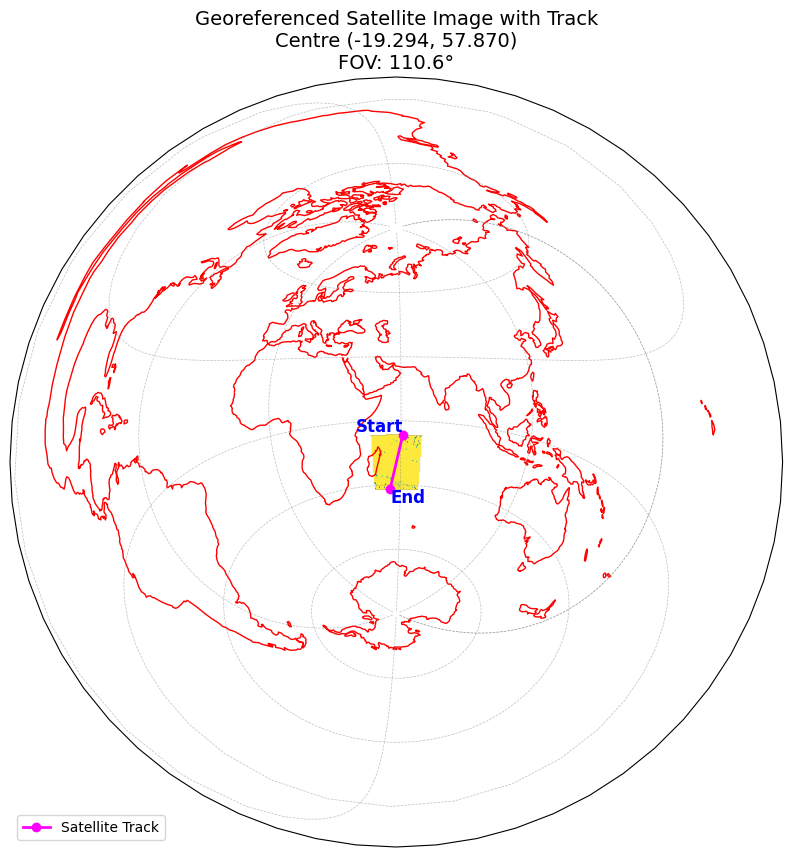

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cartopy.crs as ccrs
from scipy.ndimage import rotate

# --- Load image ---
img_path = "2025-07-11_05-39_noaa_apt_137MHz/AVHRR-2.png"
img = np.array(Image.open(img_path).convert("L"), dtype=np.float32)

# --- Metrics from product ---
centre_lat = metrics['mid_subpoint']['lat_deg']
centre_lon = metrics['mid_subpoint']['lon_deg']
swath_km = metrics['across_track_swath_km']
track_km = metrics['along_track_length_km']

start_lat, start_lon = metrics['first_subpoint']['lat_deg'], metrics['first_subpoint']['lon_deg']
end_lat, end_lon = metrics['last_subpoint']['lat_deg'], metrics['last_subpoint']['lon_deg']

# --- Compute along-track orientation angle ---
delta_lat = end_lat - start_lat
delta_lon = end_lon - start_lon
angle_rad = np.arctan2(delta_lon, delta_lat)
angle_deg = np.rad2deg(angle_rad)

# --- Rotate image so along-track aligns north-south ---
img_rot = rotate(img, -angle_deg, reshape=True, order=1, mode='nearest')

# --- Compute extent in degrees ---
earth_radius_km = 6371.0
lat_extent = (track_km / 2) / (2 * np.pi * earth_radius_km / 360)
lon_extent = (swath_km / 2) / (2 * np.pi * earth_radius_km / 360 * np.cos(np.deg2rad(centre_lat)))

extent = [
    centre_lon - lon_extent, centre_lon + lon_extent,
    centre_lat - lat_extent, centre_lat + lat_extent
]

# --- Plot ---
proj = ccrs.AzimuthalEquidistant(central_longitude=centre_lon, central_latitude=centre_lat)
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=proj)

# Display rotated image
ax.imshow(img_rot, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap='viridis', alpha=0.9)

# Overlay coastlines and grid
ax.coastlines(resolution='110m', color='red')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray', alpha=0.5)
gl.top_labels = gl.right_labels = False

# Overlay satellite track
ax.plot([start_lon, end_lon], [start_lat, end_lat], color='magenta', linewidth=2,
        marker='o', transform=ccrs.PlateCarree(), label='Satellite Track')

# Annotate start and end points
ax.text(start_lon, start_lat, 'Start', color='blue', fontsize=12, fontweight='bold',
        transform=ccrs.PlateCarree(), ha='right', va='bottom')
ax.text(end_lon, end_lat, 'End', color='blue', fontsize=12, fontweight='bold',
        transform=ccrs.PlateCarree(), ha='left', va='top')

plt.title(f"Georeferenced Satellite Image with Track\nCentre ({centre_lat:.3f}, {centre_lon:.3f})\nFOV: {metrics['fov_deg']:.1f}°", fontsize=14)
plt.legend(loc='lower left')
plt.show()


This code overlays a NOAA AVHRR satellite image on a world map using approximate geometric calculations. It loads the image, extracts the satellite’s midpoint latitude and longitude, and estimates the image’s ground coverage (along-track and across-track) in kilometers. These distances are then converted into degrees of latitude and longitude to define a rectangular geographic extent around the image center. Using Cartopy’s Plate Carrée projection, the image is displayed with coastlines and gridlines for reference. While this provides a rough geolocation, it assumes the image covers a simple rectangular area aligned with latitude and longitude, so some positional offset or distortion can occur because real satellite ground tracks are curved and not perfectly aligned to geographic grids.


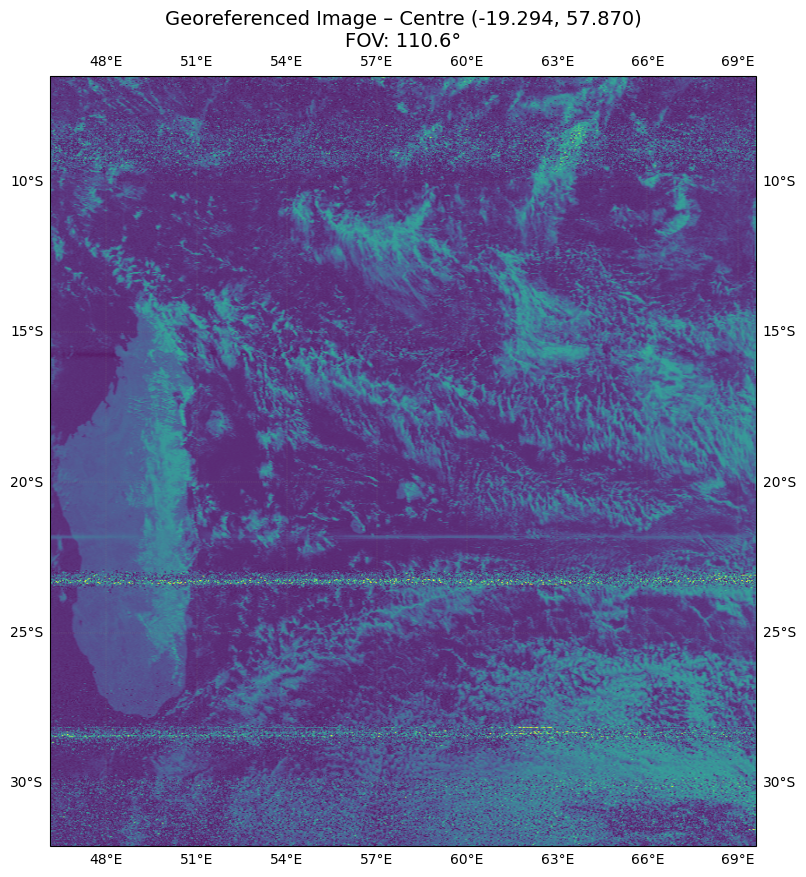

In [9]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# --- Load image ---
img_path = "2025-07-11_05-39_noaa_apt_137MHz/AVHRR-2.png"
img = np.array(Image.open(img_path))

centre_lat = metrics['mid_subpoint']['lat_deg']
centre_lon = metrics['mid_subpoint']['lon_deg']
swath_km = metrics['across_track_swath_km']
track_km = metrics['along_track_length_km']

# --- Compute km per degree ---
earth_radius_km = 6371.0
km_per_deg_lat = (2 * np.pi * earth_radius_km) / 360.0
km_per_deg_lon = km_per_deg_lat * np.cos(np.deg2rad(centre_lat))

# --- Compute geographic half-extents ---
lat_half = (track_km / 2) / km_per_deg_lat
lon_half = (swath_km / 2) / km_per_deg_lon

extent = [
    centre_lon - lon_half, centre_lon + lon_half,
    centre_lat - lat_half, centre_lat + lat_half
]

# --- Plot ---
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

# keep gridlines only (remove coastlines)
ax.gridlines(draw_labels=True, linewidth=0.3, linestyle='--', color='gray', alpha=0.5)

# --- Display image ---
ax.imshow(img, extent=extent, transform=ccrs.PlateCarree(),
          origin='upper', alpha=0.9)

plt.title(f"Georeferenced Image – Centre ({centre_lat:.3f}, {centre_lon:.3f})\nFOV: {metrics['fov_deg']:.1f}°", fontsize=14)
plt.show()


/var/folders/v0/v_qnst7n3hn5fdcjh69y2qvm0000gn/T/ipykernel_5674/2225146992.py:51: RuntimeWarning: invalid value encountered in cast
  img_resampled[b] = griddata(


GeoTIFF saved: AVHRR-2-Georeferenced.tif


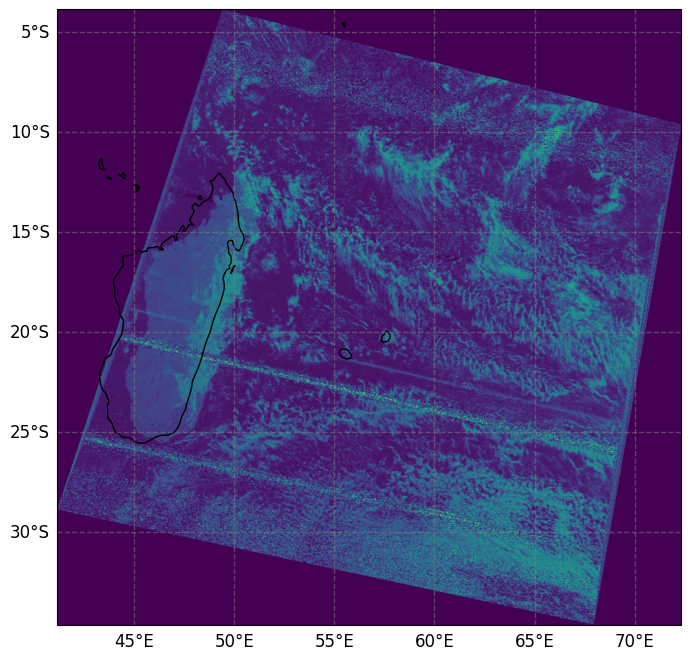

In [10]:
import numpy as np
from PIL import Image
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load image
img = np.array(Image.open("2025-07-11_05-39_noaa_apt_137MHz/AVHRR-2.png"))
height, width = img.shape[:2]

# Satellite metrics
metrics = metrics

# Along-track interpolation
along_lats = np.linspace(metrics['first_subpoint']['lat_deg'],
                         metrics['last_subpoint']['lat_deg'], height)
along_lons = np.linspace(metrics['first_subpoint']['lon_deg'],
                         metrics['last_subpoint']['lon_deg'], height)

# Track and perpendicular angles
delta_lat = metrics['last_subpoint']['lat_deg'] - metrics['first_subpoint']['lat_deg']
delta_lon = metrics['last_subpoint']['lon_deg'] - metrics['first_subpoint']['lon_deg']
track_angle = np.arctan2(delta_lat, delta_lon)
perp_angle = track_angle + np.pi / 2

# Across-track offsets
mean_lat = np.mean([metrics['first_subpoint']['lat_deg'], metrics['last_subpoint']['lat_deg']])
km_per_deg_lon = 111 * np.cos(np.radians(mean_lat))
swath_half_deg = (metrics['across_track_swath_km'] / km_per_deg_lon) / 2
across_offsets = np.linspace(-swath_half_deg, swath_half_deg, width)

# Build lat/lon grid
cos_lat = np.cos(np.radians(along_lats))[:, None]
lats_grid = along_lats[:, None] + across_offsets * np.sin(perp_angle)
lons_grid = along_lons[:, None] + (across_offsets * np.cos(perp_angle)) / cos_lat

# Interpolate onto regular grid for GeoTIFF
lat_target = np.linspace(lats_grid.min(), lats_grid.max(), height)
lon_target = np.linspace(lons_grid.min(), lons_grid.max(), width)
lon_target_2d, lat_target_2d = np.meshgrid(lon_target, lat_target)

if img.ndim == 2:
    img = img[np.newaxis, :, :]
else:
    img = img.transpose(2,0,1)

img_resampled = np.zeros((img.shape[0], height, width), dtype=img.dtype)
for b in range(img.shape[0]):
    img_resampled[b] = griddata(
        points=(lons_grid.flatten(), lats_grid.flatten()),
        values=img[b].flatten(),
        xi=(lon_target_2d, lat_target_2d),
        method='linear'
    )

# Flip vertically for GeoTIFF convention
img_resampled = img_resampled[:, ::-1, :]

# Save GeoTIFF
transform = from_origin(
    west=lon_target.min(),
    north=lat_target.max(),
    xsize=(lon_target.max()-lon_target.min())/(width-1),
    ysize=(lat_target.max()-lat_target.min())/(height-1)
)

out_path = "AVHRR-2-Georeferenced.tif"
with rasterio.open(
    out_path, 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=img_resampled.shape[0],
    dtype=img_resampled.dtype,
    crs='EPSG:4326',
    transform=transform
) as dst:
    dst.write(img_resampled)

print(f"GeoTIFF saved: {out_path}")

# Plot exactly what is saved
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size':12}
gl.ylabel_style = {'size':12}

img_plot = img_resampled.transpose(1,2,0)
ax.imshow(img_plot,
          extent=[lon_target.min(), lon_target.max(), lat_target.min(), lat_target.max()],
          origin='upper',
          transform=ccrs.PlateCarree())
plt.show()

### Radiometric Analysis
This code loads a satellite image, splits it into channels if needed, and computes basic radiometric statistics such as mean, standard deviation, min/max values, dynamic range, and SNR. It plots histograms to show pixel intensity distributions and applies contrast enhancement using percentile stretching and histogram equalization. The code also checks for under- or overexposed pixels and provides a summary of the results.

Loaded image with 1 channel(s), shape=(860, 909)

--- Channel 1 Radiometric Stats ---
mean           : 12012.9512
std            : 8587.3320
min            : 0.0000
max            : 65535.0000
dynamic_range  : 65535.0000
snr_db         : 2.9158


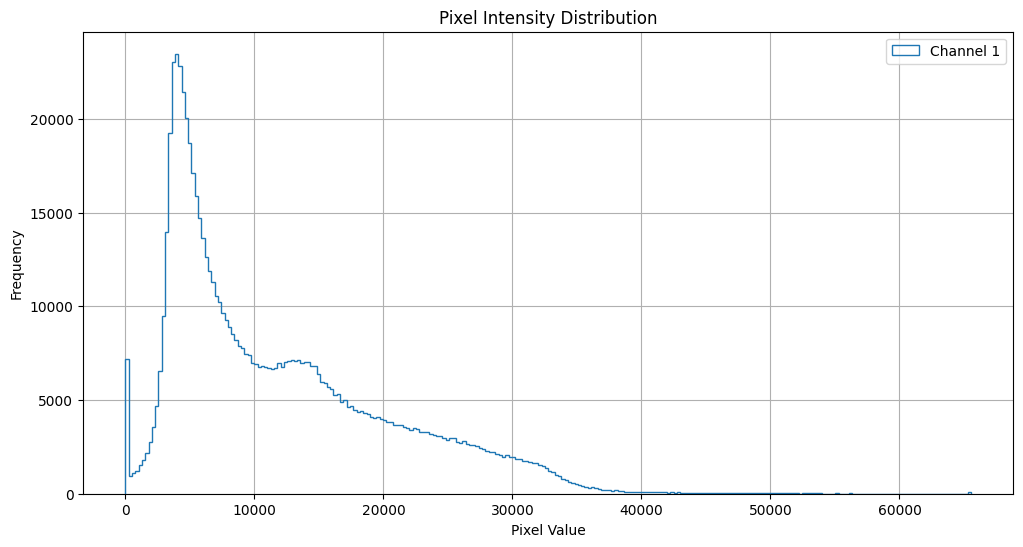

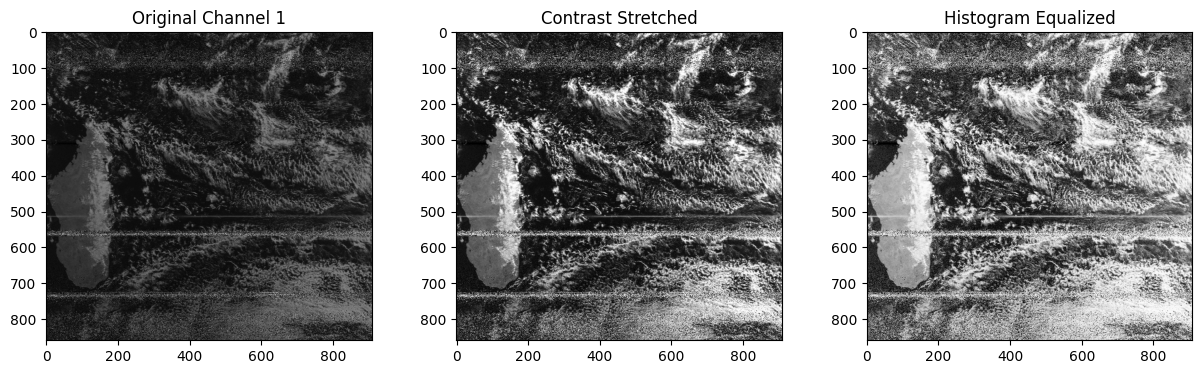


Channel 1:
  Underexposed pixels: 1.00%
  Overexposed pixels : 1.00%

Summary: {'channel_stats': [{'mean': 12012.951171875, 'std': 8587.33203125, 'min': 0.0, 'max': 65535.0, 'dynamic_range': 65535.0, 'snr_db': 2.9158291302057493}]}


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import exposure
import json

# ===========================
# 1. Load Image
# ===========================

# Read image (keep float precision)
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

if img is None:
    raise FileNotFoundError(f"Could not load {img_path}")

# Convert to float32 for analysis
img = img.astype(np.float32)

# If image has multiple channels, split them
if len(img.shape) == 3:
    channels = cv2.split(img)
else:
    channels = [img]

print(f"Loaded image with {len(channels)} channel(s), shape={img.shape}")

# ===========================
# 2. Radiometric Statistics
# ===========================
def radiometric_stats(channel):
    mean = float(np.mean(channel))
    std = float(np.std(channel))
    min_val = float(np.min(channel))
    max_val = float(np.max(channel))
    dynamic_range = float(max_val - min_val)
    snr = float(10 * np.log10(mean**2 / std**2)) if std > 0 else float('inf')

    return {
        "mean": mean,
        "std": std,
        "min": min_val,
        "max": max_val,
        "dynamic_range": dynamic_range,
        "snr_db": snr,
    }

channel_stats = [radiometric_stats(ch) for ch in channels]

for i, stats in enumerate(channel_stats):
    print(f"\n--- Channel {i+1} Radiometric Stats ---")
    for k, v in stats.items():
        print(f"{k:15}: {v:.4f}")

# ===========================
# 3. Histogram Analysis
# ===========================
plt.figure(figsize=(12, 6))
for i, ch in enumerate(channels):
    plt.hist(ch.ravel(), bins=256, histtype='step', label=f'Channel {i+1}')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# ===========================
# 4. Image Contrast & Exposure
# ===========================
for i, ch in enumerate(channels):
    # Compute histogram equalization and contrast stretching
    p2, p98 = np.percentile(ch, (2, 98))
    stretched = exposure.rescale_intensity(ch, in_range=(p2, p98))
    eq = exposure.equalize_hist(ch)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    axs[0].imshow(ch, cmap='gray')
    axs[0].set_title(f'Original Channel {i+1}')
    axs[1].imshow(stretched, cmap='gray')
    axs[1].set_title('Contrast Stretched')
    axs[2].imshow(eq, cmap='gray')
    axs[2].set_title('Histogram Equalized')
    plt.show()

# ===========================
# 5. Exposure / Clipping Detection
# ===========================
def exposure_quality(channel, low_thresh=0.01, high_thresh=0.99):
    """Detect over/underexposure by checking pixel percentile clipping."""
    low_val, high_val = np.percentile(channel, [low_thresh * 100, high_thresh * 100])
    underexposed = np.sum(channel <= low_val) / channel.size
    overexposed = np.sum(channel >= high_val) / channel.size
    return float(underexposed), float(overexposed)

for i, ch in enumerate(channels):
    under, over = exposure_quality(ch)
    print(f"\nChannel {i+1}:")
    print(f"  Underexposed pixels: {under * 100:.2f}%")
    print(f"  Overexposed pixels : {over * 100:.2f}%")

# ===========================
# 6. Optional: Save Analysis Summary
# ===========================
summary = {"channel_stats": channel_stats}
# with open("radiometric_analysis_summary.json", "w") as f:
#     json.dump(summary, f, indent=4)

print("\nSummary:", summary)


# Temporal Analysis of NOAA Image Channels

This section demonstrates **temporal analysis** between two SatDump image channels — **Channel A** and **Channel B** — captured at different times over the same region. The goal is to detect **long-term changes** (e.g., vegetation or land cover shifts) and **short-term transients** (e.g., clouds, floods, fires).

We use **NumPy** for computations, **OpenCV** for image handling, and **Matplotlib** for visualization.

### Step 2
Load the two channels (A and B) as `float32` arrays for precision. If the data are multi-band, convert them to grayscale for easier comparison, ensuring both have the same shape.

### Step 3
Normalize both channels to the range `[0, 1]` to remove bias from brightness or scaling differences.

### Step 4
Compute pixel-wise differences:
$$
D = B - A
$$
Positive values show brightening, negative values show darkening. Apply a threshold (e.g., 0.15) to create a **binary change mask** highlighting significant changes between the two channels.

### Step 5
Detect **transient features** — temporary phenomena appearing in one channel but not the other — using positive change thresholds and morphological filtering to remove random noise.

### Step 6
Visualize:
- **Top row:** Channels A and B, and their absolute difference  
- **Bottom row:** Normalized difference, binary change mask, and transient mask  

This allows clear identification of both stable and short-lived variations.

### Step 7
Compute the proportion of changed and transient pixels to quantify how much of the region’s radiometric properties varied between Channels A and B.


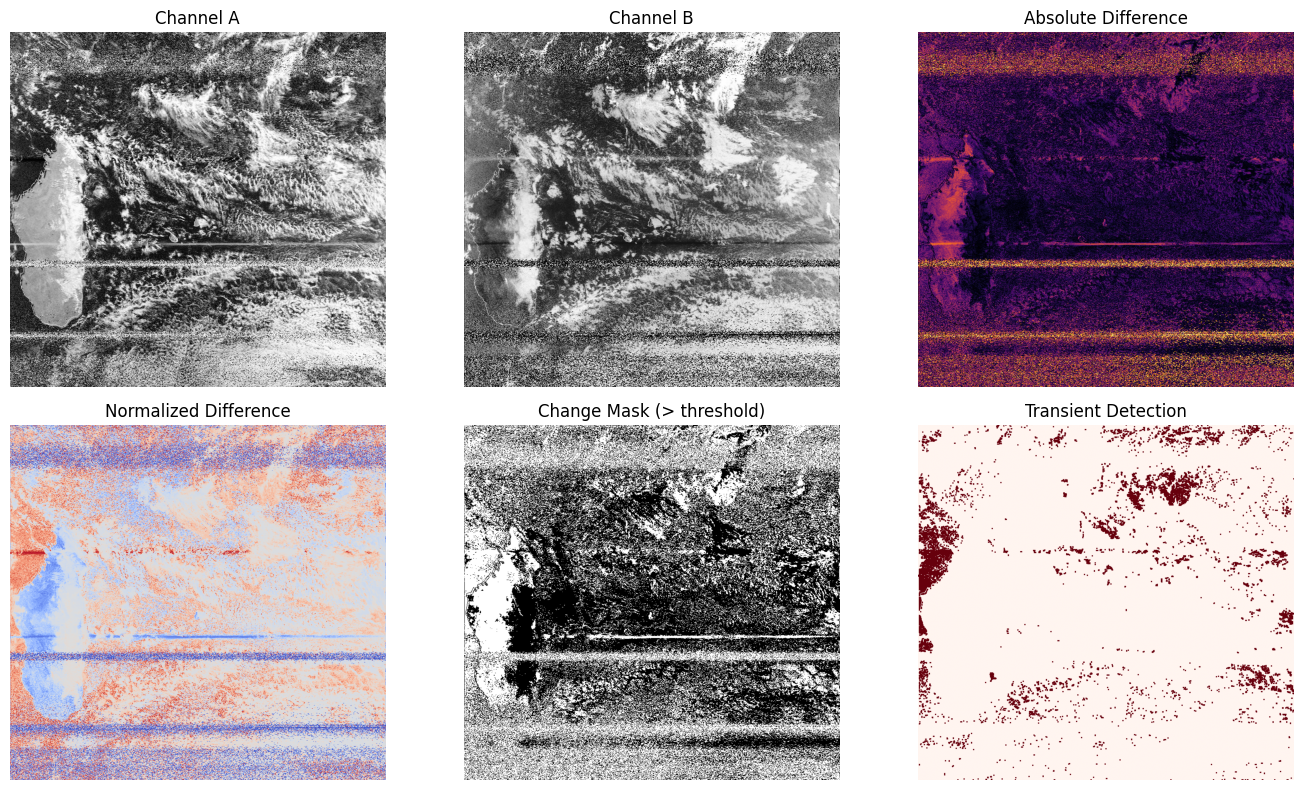


Change area: 47.09% of image
Transient area: 7.13% of image


In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ===========================
# 1. Load two SatDump images
# ===========================
img_t1 = cv2.imread("2025-07-11_05-39_noaa_apt_137MHz/avhrr_3_APT_channel_A_map.jpg", cv2.IMREAD_UNCHANGED).astype(np.float32)
img_t2 = cv2.imread("2025-07-11_05-39_noaa_apt_137MHz/avhrr_3_APT_channel_B_map.jpg", cv2.IMREAD_UNCHANGED).astype(np.float32)

# Convert to grayscale if needed
if img_t1.ndim == 3:
    img_t1 = cv2.cvtColor(img_t1, cv2.COLOR_BGR2GRAY)
if img_t2.ndim == 3:
    img_t2 = cv2.cvtColor(img_t2, cv2.COLOR_BGR2GRAY)

# Optional: resize if dimensions differ slightly
if img_t1.shape != img_t2.shape:
    img_t2 = cv2.resize(img_t2, (img_t1.shape[1], img_t1.shape[0]))

# ===========================
# 2. Normalize to [0,1]
# ===========================
img_t1 = cv2.normalize(img_t1, None, 0, 1, cv2.NORM_MINMAX)
img_t2 = cv2.normalize(img_t2, None, 0, 1, cv2.NORM_MINMAX)

# ===========================
# 3. Change Detection
# ===========================
diff = img_t2 - img_t1                     # signed difference
abs_diff = np.abs(diff)                    # absolute change
norm_diff = (diff) / (img_t2 + img_t1 + 1e-6)  # normalized difference

# Threshold for significant change
threshold = 0.15
change_mask = (abs_diff > threshold).astype(np.uint8)

# ===========================
# 4. Transient Detection
# ===========================
# Simple transient = brightening beyond threshold
transient_mask = ((img_t2 - img_t1) > threshold).astype(np.uint8)

# Remove small noise via morphological opening
kernel = np.ones((3, 3), np.uint8)
transient_mask = cv2.morphologyEx(transient_mask, cv2.MORPH_OPEN, kernel)

# ===========================
# 5. Visualization
# ===========================
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
axs[0, 0].imshow(img_t1, cmap='gray'); axs[0, 0].set_title("Channel A")
axs[0, 1].imshow(img_t2, cmap='gray'); axs[0, 1].set_title("Channel B")
axs[0, 2].imshow(abs_diff, cmap='inferno'); axs[0, 2].set_title("Absolute Difference")

axs[1, 0].imshow(norm_diff, cmap='coolwarm'); axs[1, 0].set_title("Normalized Difference")
axs[1, 1].imshow(change_mask, cmap='gray'); axs[1, 1].set_title("Change Mask (> threshold)")
axs[1, 2].imshow(transient_mask, cmap='Reds'); axs[1, 2].set_title("Transient Detection")
for ax in axs.flat: ax.axis('off')
plt.tight_layout()
plt.show()

# ===========================
# 6. Summary Statistics
# ===========================
change_ratio = np.sum(change_mask) / change_mask.size * 100
transient_ratio = np.sum(transient_mask) / transient_mask.size * 100

print(f"\nChange area: {change_ratio:.2f}% of image")
print(f"Transient area: {transient_ratio:.2f}% of image")



## Merging Images
We will compare two NOAA APT satellite channels (A and B) to highlight spatial and spectral differences. It loads both grayscale images, creates a fused image (average of A and B) and a difference map (A – B), and visualises these alongside the original channels. Using ground distance metrics, it scales the difference map to real-world units (km²) and plots it with proper axes. Finally, it obtains the  summary statistics — such as mean fused and difference values for further analysis.


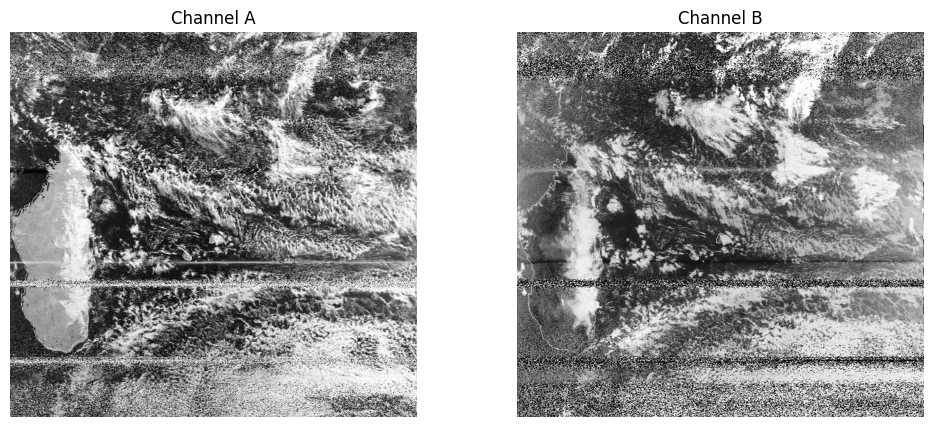

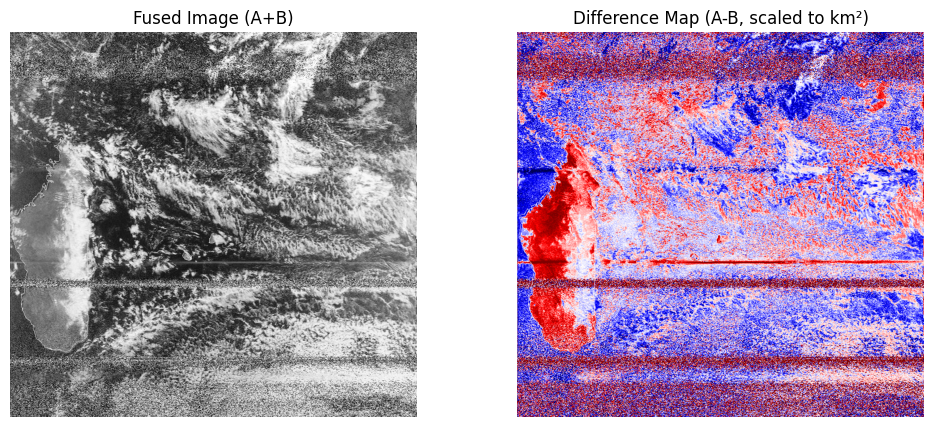

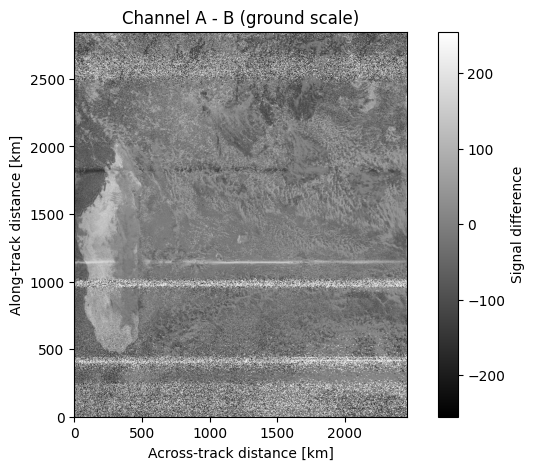

Advanced analysis complete. Summary saved to 'advanced_analysis_summary.json'


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from rasterio.transform import from_bounds
import json

# --- FILE PATHS ---
channel_a_path = "2025-07-11_05-39_noaa_apt_137MHz/avhrr_3_APT_channel_A_map.jpg"
channel_b_path = "2025-07-11_05-39_noaa_apt_137MHz/avhrr_3_APT_channel_B_map.jpg"

# --- STEP 0: Load images ---
img_a = np.array(Image.open(channel_a_path).convert('L'), dtype=np.float32)
img_b = np.array(Image.open(channel_b_path).convert('L'), dtype=np.float32)
height, width = img_a.shape

# Ground-referenced distances
along_track_km = metrics['along_track_length_km']
swath_km = metrics['across_track_swath_km']
per_pixel_km2 = metrics['per_pixel_area_km2']

# --- STEP 2: Visualize the original images ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_a, cmap='gray')
plt.title("Channel A")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_b, cmap='gray')
plt.title("Channel B")
plt.axis("off")
plt.show()

# --- STEP 3: Difference / Fusion ---
fused = (img_a + img_b) / 2.0
difference = img_a - img_b

# Scale difference by per-pixel ground area for teaching purposes
difference_ground = difference / per_pixel_km2

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].imshow(fused, cmap='gray')
ax[0].set_title("Fused Image (A+B)")
ax[0].axis("off")

ax[1].imshow(difference_ground, cmap='seismic', 
             vmin=-np.std(difference_ground)*2, vmax=np.std(difference_ground)*2)
ax[1].set_title("Difference Map (A-B, scaled to km²)")
ax[1].axis("off")
plt.show()

# --- STEP 4: Ground-referenced plot ---
plt.figure(figsize=(8,5))
plt.imshow(difference, cmap='gray', extent=[0, swath_km, 0, along_track_km], origin='upper')
plt.title("Channel A - B (ground scale)")
plt.xlabel("Across-track distance [km]")
plt.ylabel("Along-track distance [km]")
plt.colorbar(label="Signal difference")
plt.show()

# --- STEP 5: Save summary ---
advanced_summary = {
    "fusion": {
        "performed": True,
        "fused_mean": float(np.mean(fused)),
        "difference_mean": float(np.mean(difference))
    },
    "metrics": metrics
}

with open("advanced_analysis_summary.json", "w") as f:
    json.dump(advanced_summary, f, indent=4)

print("Advanced analysis complete. Summary saved to 'advanced_analysis_summary.json'")


In [14]:
ls 2025-07-11_05-39_noaa_apt_137MHz/

APT-A.png
APT-B.png
avhrr_3_APT_channel_A_corrected.jpg
avhrr_3_APT_channel_A_map.jpg
avhrr_3_APT_channel_A.jpg
avhrr_3_APT_channel_B_corrected.jpg
avhrr_3_APT_channel_B_map.jpg
avhrr_3_APT_channel_B.jpg
avhrr_3_rgb_10.8um_Thermal_IR_corrected.jpg
avhrr_3_rgb_10.8um_Thermal_IR.jpg
avhrr_3_rgb_Cloud_Top_IR_corrected.jpg
avhrr_3_rgb_Cloud_Top_IR_map.jpg
avhrr_3_rgb_Cloud_Top_IR.jpg
avhrr_3_rgb_MCIR_(Uncalibrated)_map.jpg
avhrr_3_rgb_MCIR_(Uncalibrated).jpg
avhrr_3_rgb_MCIR_map.jpg
avhrr_3_rgb_MCIR_Rain_(Uncalibrated)_map.jpg
avhrr_3_rgb_MCIR_Rain_(Uncalibrated).jpg
avhrr_3_rgb_MCIR.jpg
avhrr_3_rgb_MSA_(channel_2)_corrected.jpg
avhrr_3_rgb_MSA_(channel_2)_map.jpg
avhrr_3_rgb_MSA_(channel_2).jpg
avhrr_3_rgb_MSA_(Uncalibrated)_map.jpg
avhrr_3_rgb_MSA_(Uncalibrated).jpg
avhrr_3_rgb_NO_enhancement_map.jpg
avhrr_3_rgb_NO_enhancement.jpg
AVHRR-2.png
AVHRR-4.png
channel_4_projected.jpg
dataset.json
product.cbor
raw_sync.jpg
raw_unsync.jpg


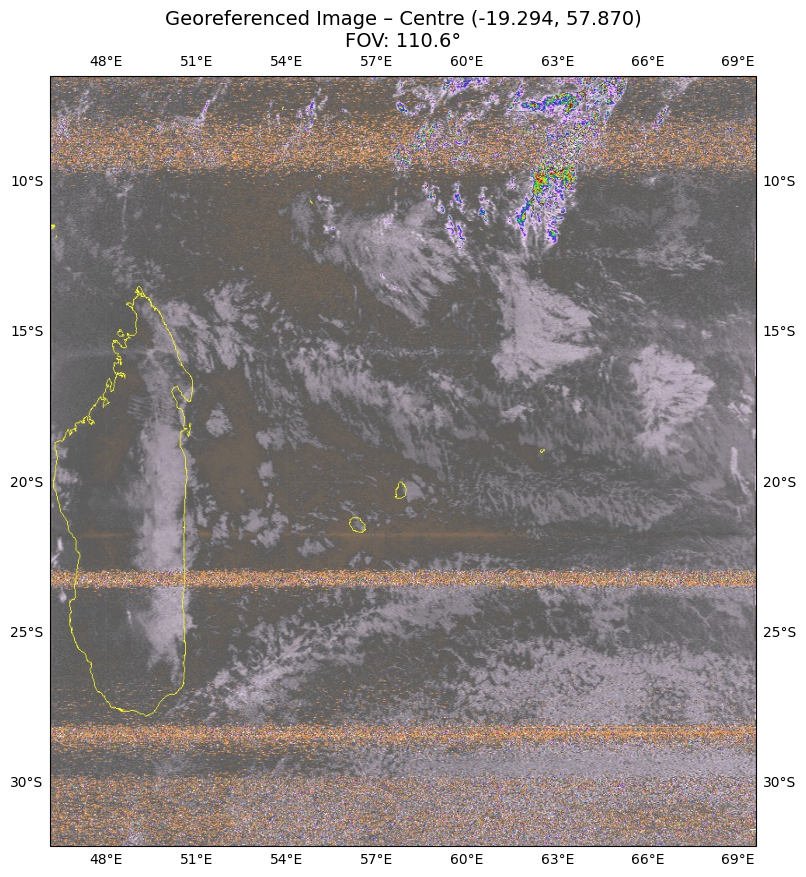

In [16]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# --- Load image ---
img_path = "2025-07-11_05-39_noaa_apt_137MHz/avhrr_3_rgb_NO_enhancement_map.jpg"
img = np.array(Image.open(img_path))

centre_lat = metrics['mid_subpoint']['lat_deg']
centre_lon = metrics['mid_subpoint']['lon_deg']
swath_km = metrics['across_track_swath_km']
track_km = metrics['along_track_length_km']

# --- Compute km per degree ---
earth_radius_km = 6371.0
km_per_deg_lat = (2 * np.pi * earth_radius_km) / 360.0
km_per_deg_lon = km_per_deg_lat * np.cos(np.deg2rad(centre_lat))

# --- Compute geographic half-extents ---
lat_half = (track_km / 2) / km_per_deg_lat
lon_half = (swath_km / 2) / km_per_deg_lon

extent = [
    centre_lon - lon_half, centre_lon + lon_half,
    centre_lat - lat_half, centre_lat + lat_half
]

# --- Plot ---
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

# keep gridlines only (remove coastlines)
ax.gridlines(draw_labels=True, linewidth=0.3, linestyle='--', color='gray', alpha=0.5)

# --- Display image ---
ax.imshow(img, extent=extent, transform=ccrs.PlateCarree(),
          origin='upper', alpha=0.9)

plt.title(f"Georeferenced Image – Centre ({centre_lat:.3f}, {centre_lon:.3f})\nFOV: {metrics['fov_deg']:.1f}°", fontsize=14)
plt.show()



## Additional Resources

Intro to Python: Check out Week 1 and 2 of <https://github.com/Danselem/brics_astro>

Introduction to GIS Programming: <https://github.com/giswqs/geog-312>

### Advanced

GeoAI: Artificial Intelligence for Geospatial Data: <https://opengeoai.org/>

Disaster Risk Monitoring with Satellite Imagery: <https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+S-ES-01+V1>